<a href="https://colab.research.google.com/github/adebolarahman17/Boxes/blob/main/Copy_of_Boxes_detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
import os

images =os.listdir('/content/drive/MyDrive/Boxes')
targets=[]
for image in images:
  target = image.split('_')[0]
  if target == 'Nondefective':
    targets.append(0)
  else:
    targets.append(1)



In [ ]:
data = pd.DataFrame({
    'image': images,
    'target': targets
})
data

,image,target
0,defective_329.jpg,1
1,defective_159.jpg,1
2,defective_144.jpg,1
3,defective_210.jpg,1
4,defective_199.jpg,1
...,...,...
1053,defective_21.jpg,1
1054,defective_135.jpg,1
1055,defective_169.jpg,1
1056,defective_145.jpg,1


In [ ]:
data[data['target']=='Nondefective']

,image,target
18,Nondefective_956.jpg,Nondefective
19,Nondefective_974.jpg,Nondefective
52,Nondefective_312.jpg,Nondefective
55,Nondefective_917.jpg,Nondefective
59,Nondefective_916.jpg,Nondefective
...,...,...
1018,Nondefective_16.jpg,Nondefective
1021,Nondefective_915.jpg,Nondefective
1029,Nondefective_973.jpg,Nondefective
1039,Nondefective_869.jpg,Nondefective


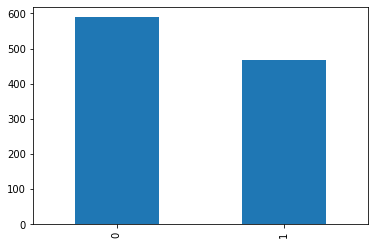

In [ ]:
data['target'].value_counts().plot.bar()

In [ ]:
base_model=MobileNet(weights='imagenet',include_top=False)  #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)                          #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x)                          #dense layer 2
x=Dense(512,activation='relu')(x)                           #dense layer 3
preds=Dense(2,activation='softmax')(x)                      #final layer with softmax activation

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
model=Model(inputs=base_model.input,outputs=preds)

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy']) 

In [ ]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [ ]:
earlystop = EarlyStopping(patience=10)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
data["target"] = data["target"].replace({0: 'Nondefective', 1: 'defective'}) 

In [ ]:
train_df, validate_df = train_test_split(data, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)


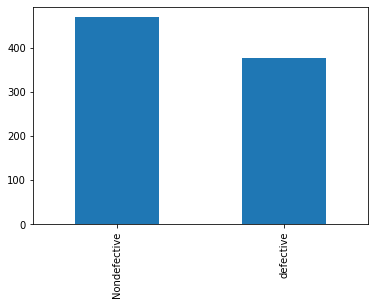

In [ ]:
train_df['target'].value_counts().plot.bar()

In [ ]:
train_df['target'].value_counts()

Nondefective    469
defective       377
Name: target, dtype: int64

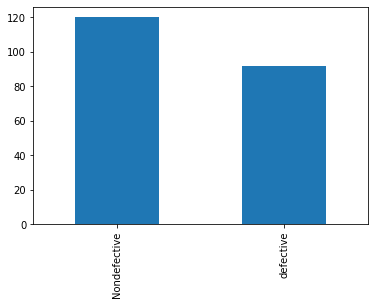

In [ ]:
validate_df['target'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    '/content/drive/MyDrive/Boxes', 
    x_col='image',
    y_col='target',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 845 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    '/content/drive/MyDrive/Boxes', 
    x_col='image',
    y_col='target',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
) 

Found 212 validated image filenames belonging to 2 classes.


In [ ]:
validate_df['target']

0      Nondefective
1         defective
2      Nondefective
3         defective
4      Nondefective
           ...     
207       defective
208       defective
209    Nondefective
210       defective
211       defective
Name: target, Length: 212, dtype: object

In [ ]:
target_names = []

for key in train_generator.class_indices:

    target_names.append(key)



print(target_names)

['Nondefective', 'defective']


In [ ]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
56/56 [==============================] - 798s 14s/step - loss: 0.5568 - accuracy: 0.7675 - val_loss: 1.8783 - val_accuracy: 0.5952 - lr: 0.0010
Epoch 2/50
56/56 [==============================] - 159s 3s/step - loss: 0.3770 - accuracy: 0.8458 - val_loss: 2.8557 - val_accuracy: 0.6048 - lr: 0.0010
Epoch 3/50
56/56 [==============================] - 158s 3s/step - loss: 0.3372 - accuracy: 0.8614 - val_loss: 2.1273 - val_accuracy: 0.6571 - lr: 0.0010
Epoch 4/50
56/56 [==============================] - 157s 3s/step - loss: 0.3031 - accuracy: 0.8771 - val_loss: 0.6857 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 5/50
56/56 [==============================] - 157s 3s/step - loss: 0.2787 - accuracy: 0.8855 - val_loss: 0.8132 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 6/50
56/56 [==============================] - ETA: 0s - loss: 0.2901 - accuracy: 0.8819
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
56/56 [==============================] - 158s 3s/step -

In [ ]:
model.save_weights("model.boxes")

In [ ]:
model.save('/content/drive/My Drive/Boxes/model.boxes')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Boxes/model.boxes/assets


In [ ]:
Y_pred = model.predict_generator(validation_generator)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(validation_generator.classes, y_pred)
print(cm)

#plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Confusion Matrix
[[71 49]
 [53 39]]


In [ ]:
y_pred


array([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0])

In [ ]:
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

Nondefective       0.57      0.59      0.58       120
   defective       0.44      0.42      0.43        92

    accuracy                           0.52       212
   macro avg       0.51      0.51      0.51       212
weighted avg       0.52      0.52      0.52       212



In [ ]:
test =os.listdir('/content/drive/MyDrive/test_file')

In [ ]:
test_df = pd.DataFrame({
    'filename': test
})
nb_samples = test_df.shape[0]

In [ ]:
test_df

,filename
0,defective_53.jpg
1,defective_42.jpg
2,defective_47.jpg
3,defective_40.jpg
4,defective_46.jpg
...,...
147,Nondefective_74.jpg
148,Nondefective_66.jpg
149,Nondefective_6.jpg
150,Nondefective_60.jpg


In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    '/content/drive/MyDrive/test_file', 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 152 validated image filenames.


In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
#predict

In [ ]:
test_df['target'] = np.argmax(predict, axis=1)

In [ ]:
test_df

,filename,target
0,defective_53.jpg,1
1,defective_42.jpg,1
2,defective_47.jpg,1
3,defective_40.jpg,1
4,defective_46.jpg,1
...,...,...
147,Nondefective_74.jpg,0
148,Nondefective_66.jpg,0
149,Nondefective_6.jpg,0
150,Nondefective_60.jpg,0


In [ ]:
model = load_model('/content/drive/My Drive/Boxes/model.boxes')

In [ ]:
def load_image(img_path):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    return img_tensor

In [ ]:
load_image()

In [ ]:
def prediction(img_path):
    new_image = load_image(img_path)
    
    pred = model.predict(new_image)
    
    print(pred)
    
    labels=np.array(pred)
    labels[labels>=0.5]=1
    labels[labels<0.5]=0
    
    print(labels)
    final=np.array(labels)
    
    if final[0][0]==1:
        return "Bad"
    else:
        return "Good"

In [ ]:
prediction('/content/drive/MyDrive/test_file/Nondefective_77.jpg')

[[9.9999821e-01 1.8033538e-06]]
[[1. 0.]]


'Bad'

In [ ]:
[[71 49]
 [53 39]]

**The Confusiion Matrix output as shown above**

In [ ]:
True Positive (TP): Out of 92 actual positive,  39 is correctly predicted positive (TP).
False Positive (FP): Out of 124 actual negative, 53 is falsely predicted as positive (FP).
True Negative (TN): Out of 120 actual negative, 71 is correctly predicted negative (TN).
False Negative (FN): Out of 88 actual positive, 49 is falsely predicted as negative (FN).  

**Do you consider the model to have been overfit or underfit? Why?**

In [ ]:
The model is an underfit one  because during testing the results were poor. 

**What model architecture did you utilise? Why?**

A Deep Learning based Convolution Neural Network Architecture known as MobileNet. One of basic models for image classification 

  **What optimiser did you utilise? What learning rate?**

I applied ReduceLROnPlateau for the learning rate

 **How many epochs did you train for? Why?**



I set my epoch as 50 because the dataset is not large. Also, too many of them lead to overfitting the data

In [ ]:
from flask import Flask, render_template                 #import

app = Flask(__name__)                                    #calling

@app.route("/", methods=['GET', 'POST'])                 #initialising
def home():                                              #function call

    return render_template('home.html')                  #return and calling HTML page (designed template)


if __name__ == "__main__":
    app.run()  

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


SyntaxError: ignored

<!DOCTYPE html>
<html>
<head>
  <!-- Required meta tags -->
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous">
    <title>Quality Check</title>
</head>
<body>

  <div class="container">
  <div class="row">

    <div class="col-sm">
      <span class="border border-primary">
        <img src="{{ user_image }}" alt="Selected Image" class="img-thumbnail">
      </span>
    </div>

    <div class="col-sm">
      <h1>Quality   <span class="badge badge-secondary">{{product}}</span></h1>
    </div>

  </div>
</div>

<script src="https://code.jquery.com/jquery-3.2.1.slim.min.js" integrity="sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN" crossorigin="anonymous"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js" integrity="sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q" crossorigin="anonymous"></script>
<script src="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js" integrity="sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl" crossorigin="anonymous"></script>
</body>
</html>

In [ ]:
from flask import Flask
from flask_ngrok import run_with_ngrok
app = Flask(__name__)
run_with_ngrok(app)   
  
@app.route("/")
def home():
    return "<h1>GFG is great platform to learn</h1>"
    
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://dd1f-34-74-53-241.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [01/Dec/2021 10:40:28] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2021 10:40:29] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [01/Dec/2021 10:41:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2021 10:41:08] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [01/Dec/2021 10:41:23] "HEAD / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2021 10:41:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2021 10:41:24] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [01/Dec/2021 10:41:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2021 10:41:46] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
!pip install flask-ngrok

In [ ]:
from flask import Flask, render_template                 #import

app = Flask(__name__)                                    #calling

@app.route("/", methods=['GET', 'POST'])                 #initialising
def home():                                              #function call

    return render_template(<html>
<head>
  <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous">
    <title>Upload Image</title>
</head>
<body>
    <div class="col-sm">
      <h1><span class="badge badge-danger">Quality Inspection</span></h1>
    </div>

    <div class="col-sm">
      <form action = "/predict" method = "post" enctype="multipart/form-data">
          <input type="file" name="file" />
          <input type = "submit" value="Upload">
      </form>
    </div>
</body>
</html>)                  #return and calling HTML page (designed template)


if __name__ == "__main__":
    app.run()      

In [ ]:
from flask import Flask
from flask_ngrok import run_with_ngrok
app = Flask(__name__)
run_with_ngrok(app)   
  
@app.route("/")
def home():
    return "<html><body>hfhf</body></html>"
    
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://281b-34-74-53-241.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [01/Dec/2021 11:09:36] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2021 11:09:37] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
from flask import Flask, render_template                 #import
from flask_ngrok import run_with_ngrok
app = Flask(__name__)                                    #calling
run_with_ngrok(app)  
@app.route("/")                 #initialising
def home():                                              #function call

    return render_template('<html><body>hfhf</body></html>')                  #return and calling HTML page (designed template)


if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://4a87-34-74-53-241.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


[2021-12-01 11:17:09,416] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-18-8bff48bdaaa5>", line 8, in home
    return render_template('<html><body>hfhf</body></htm

In [ ]:
!pip install -U ipykernel

     |████████████████████████████████| 125 kB 5.1 MB/s 
     |████████████████████████████████| 791 kB 55.9 MB/s 
     |████████████████████████████████| 374 kB 71.5 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.23 which is incompatible.
google-colab 1.0.0 requ

In [25]:
#%%writefile score.py

import tensorflow as tf
import numpy as np
import streamlit as st
from PIL import Image
import requests
from io import BytesIO


In [26]:
st.set_option('deprecation.showfileUploaderEncoding', False)
st.title("Box Image Classifier")
st.text("Provide URL of bean Image for image classification")

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
model = tf.keras.models.load_model('/content/drive/My Drive/Boxes/model.boxes')

In [29]:
%%writefile score.py
@st.cache(allow_output_mutation=True)
def load_model():
  model = tf.keras.models.load_model('/content/drive/My Drive/Boxes/model.boxes')
  return model

with st.spinner('Loading Model Into Memory....'):
  model = load_model()

classes=['Nondefective', 'defective']

def scale(image):
  image = tf.cast(image, tf.float32)
  image /= 255.0

  return tf.image.resize(image,[224,224])

def decode_img(image):
  img = tf.image.decode_jpeg(image, channels=3)
  img = scale(img)
  return np.expand_dims(img, axis=0)

path = st.text_input('Enter Image URL to Classify.. ','http://barmac.com.au/wp-content/uploads/sites/3/2016/01/Angular-Leaf-Spot-Beans1.jpg')
if path is not None:
    content = requests.get(path).content

    st.write("Predicted Class :")
    with st.spinner('classifying.....'):
      label =np.argmax(model.predict(decode_img(content)),axis=1)
      st.write(classes[label[0]])    
    st.write("")
    image = Image.open(BytesIO(content))
    st.image(image, caption='Classifying Bean Image', use_column_width=True) 

Overwriting score.py


In [30]:
!nohup streamlit run score.py &

nohup: appending output to 'nohup.out'


In [31]:
from pyngrok import ngrok

url = ngrok.connect(port=8501)
url

2021-12-01 12:54:38.335 Opening tunnel named: http-80-83d550f5-f439-4d0f-9d0a-e6ba92eba800
2021-12-01 12:54:38.342 t=2021-12-01T12:54:38+0000 lvl=info msg=start pg=/api/tunnels id=7460f350b807bd3c
2021-12-01 12:54:38.379 t=2021-12-01T12:54:38+0000 lvl=warn msg="failed to start tunnel" pg=/api/tunnels id=7460f350b807bd3c err="Your account may not run more than 2 tunnels over a single ngrok client session.\nThe tunnels already running on this session are:\ntn_21gVNpnX9NIA3rskY96Nz5p4mZK, tn_21gVNnDHkomZmIm7TgeYKnDzsVr\n\r\n\r\nERR_NGROK_324\r\n"
2021-12-01 12:54:38.390 t=2021-12-01T12:54:38+0000 lvl=info msg=end pg=/api/tunnels id=7460f350b807bd3c status=502 dur=37.082083ms


PyngrokNgrokHTTPError: ignored

In [6]:
import tensorflow as tf
import numpy as np
from flask import Flask, request, render_template
import pickle

app = Flask(__name__)
model = tf.keras.models.load_model('/content/drive/My Drive/Boxes/model.boxes')

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/getprediction',methods=['POST'])
def getprediction():    

    input = [float(x) for x in request.form.values()]
    final_input = [np.array(input)]
    prediction = model.predict(final_input)

    return render_template('index.html', output='Predicted Weight in KGs :{}'.format(prediction))
   

if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


OSError: ignored

In [3]:
import tensorflow as tf
import numpy as np
from flask import Flask, request, render_template
import pickle
import gradio as gr

In [6]:
images =os.listdir('/content/drive/MyDrive/Boxes')

In [7]:
model = tf.keras.models.load_model('/content/drive/My Drive/Boxes/model.boxes')

In [8]:
def predict_image(img):
  img_4d=img.reshape(-1,180,180,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(2)}

In [ ]:
image = gr.inputs.Image(shape=(180,180))
label = gr.outputs.Label(num_top_classes=2)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://59707.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gradio/networking.py", line 195, in predict
    prediction, durations = app.interface.process(raw_input)
  File "/usr/local/lib/python3.7/dist-packages/gradio/interface.py", line 372, in process
    processed_input, return_duration=True)
  File "/usr/local/lib/python3.7/dist-packages/gradio/interface.py", line 337, in run_prediction
    prediction = predict_fn(*processed_input)
  File "<ipython-input-8-5106b49a2664>", line 4, in predict_image
    return {class_names[i]: float(prediction[i]) for i in range(2)}
  File "<ipython-input-8-5106b49a2664>", line 4, in <dictcomp>
    return {class_names[i]: float(prediction[i]) for i in range(2)}
NameError: name 'class_names' is not defined
